관련 패키지 설치

pip install pytorch-forecasting
pip install lightning

In [1]:
pip install ipywidgets

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch import nn
import lightning.pytorch as pl
from pytorch_forecasting import TimeSeriesDataSet, NHiTS
from pytorch_forecasting.metrics import MAE, MASE

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:
df = pd.read_csv('/Users/jeonghyunyoo/Desktop/Develop/N-HiTS/electricityConsumptionAndProductioction.csv',
                 parse_dates=['DateTime'])
df.drop_duplicates(inplace=True)
print(f'data has {df.shape[0]} rows and {df.shape[1]} columns')
df.head()

data has 46007 rows and 10 columns


,DateTime,Consumption,Production,Nuclear,Wind,Hydroelectric,Oil and Gas,Coal,Solar,Biomass
0,2019-01-01 00:00:00,6352,6527,1395,79,1383,1896,1744,0,30
1,2019-01-01 01:00:00,6116,5701,1393,96,1112,1429,1641,0,30
2,2019-01-01 02:00:00,5873,5676,1393,142,1030,1465,1616,0,30
3,2019-01-01 03:00:00,5682,5603,1397,191,972,1455,1558,0,30
4,2019-01-01 04:00:00,5557,5454,1393,159,960,1454,1458,0,30


In [4]:
df.dtypes

DateTime         datetime64[ns]
Consumption               int64
Production                int64
Nuclear                   int64
Wind                      int64
Hydroelectric             int64
Oil and Gas               int64
Coal                      int64
Solar                     int64
Biomass                   int64
dtype: object

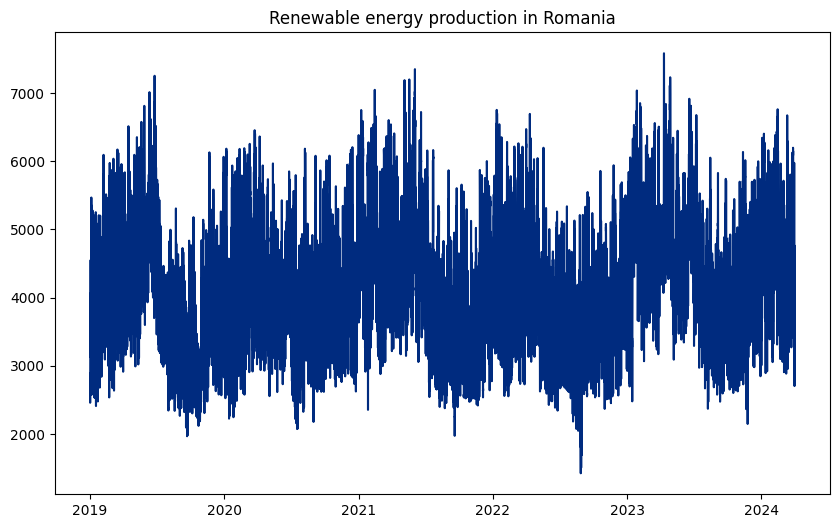

In [5]:
df['Renewable'] = df['Production'] - df['Coal'] - df['Oil and Gas']

plt.figure(figsize=(10, 6))
plt.plot(df.DateTime, df.Renewable, color='#002B7F')
plt.title('Renewable energy production in Romania');

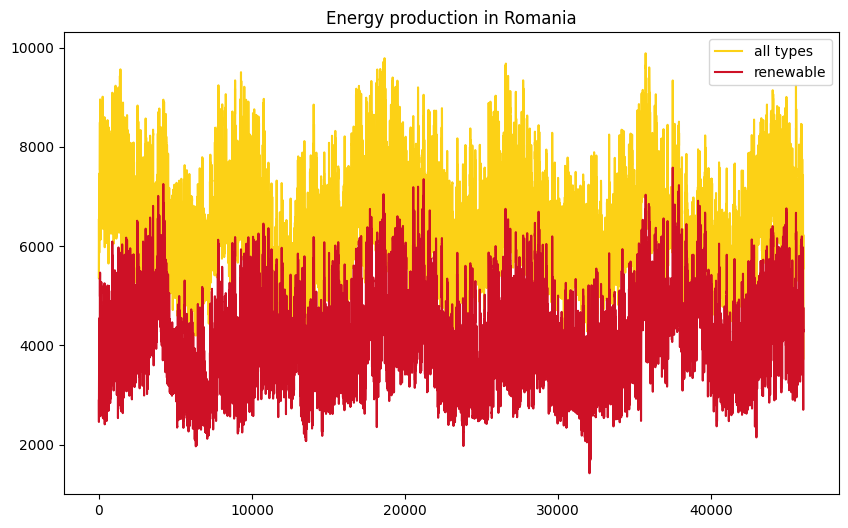

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(df.Production, color='#FCD116', label='all types')
plt.plot(df.Renewable, color='#CE1126', label='renewable')
plt.legend()
plt.title('Energy production in Romania');

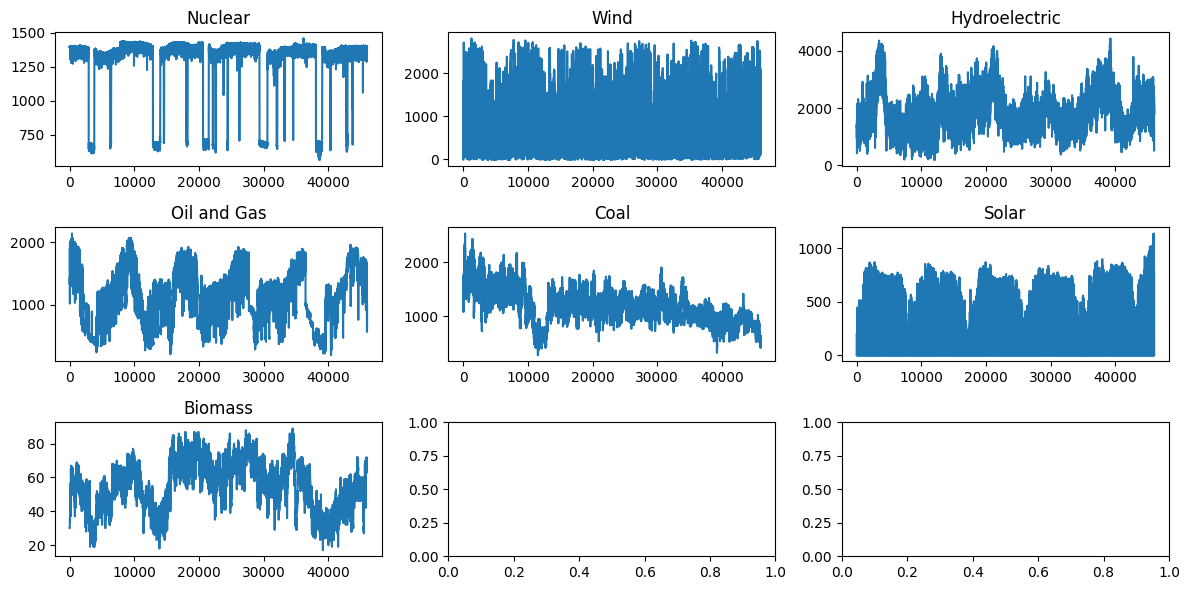

In [7]:
_, ax = plt.subplots(3, 3, tight_layout=True, figsize=(12,6))
for i, a in zip(np.arange(3, 10), ax.flat):
    a.plot(df.iloc[:, i])
    a.set_title(df.columns[i]);

In [8]:
df['group_ids'] = df.DateTime.dt.year

In [9]:
df = df.loc[df.group_ids!=2024, ['DateTime', 'group_ids', 'Renewable']]
time_idx = np.ones(2)

for i in df.group_ids.unique():
    a = df.loc[df.group_ids==i].shape[0]
    time_idx = np.concatenate((time_idx, np.arange(a)))
    
time_idx = time_idx[2:]
df['time_idx'] = time_idx

In [10]:
#change dtypes
df['time_idx'] = df.time_idx.astype('int')
df['Renewable'] = df.Renewable.astype('float')

In [11]:
df

,DateTime,group_ids,Renewable,time_idx
0,2019-01-01 00:00:00,2019,2887.0,0
1,2019-01-01 01:00:00,2019,2631.0,1
2,2019-01-01 02:00:00,2019,2595.0,2
3,2019-01-01 03:00:00,2019,2590.0,3
4,2019-01-01 04:00:00,2019,2542.0,4
...,...,...,...,...
43823,2023-12-31 19:00:00,2023,4753.0,8755
43824,2023-12-31 20:00:00,2023,4776.0,8756
43825,2023-12-31 21:00:00,2023,4909.0,8757
43826,2023-12-31 22:00:00,2023,4187.0,8758


In [12]:
OUR_HORIZON = 24*30*3
data_torch = TimeSeriesDataSet(data=df,
                               time_idx='time_idx',
                               target='Renewable',
                               group_ids=['group_ids'],
                               max_encoder_length=int(OUR_HORIZON*2),
                               max_prediction_length=int(OUR_HORIZON),
                               scalers='identity',
                               time_varying_unknown_reals=['Renewable'])

In [13]:
3*OUR_HORIZON

6480

In [14]:
train = data_torch.from_dataset(data_torch, df.iloc[:-(3*OUR_HORIZON), :])
valid = data_torch.from_dataset(data_torch, df.iloc[-(3*OUR_HORIZON):, :])
train_dataloader = train.to_dataloader(batch_size=256, num_workers=3)
valid_dataloader = valid.to_dataloader(batch_size=256, num_workers=3)

/opt/anaconda3/envs/pyver_311/lib/python3.11/site-packages/pytorch_forecasting/data/timeseries.py:1301: UserWarning: Min encoder length and/or min_prediction_idx and/or min prediction length and/or lags are too large for 1 series/groups which therefore are not present in the dataset index. This means no predictions can be made for those series. First 10 removed groups: [{'__group_id__group_ids': 2023}]
  warnings.warn(


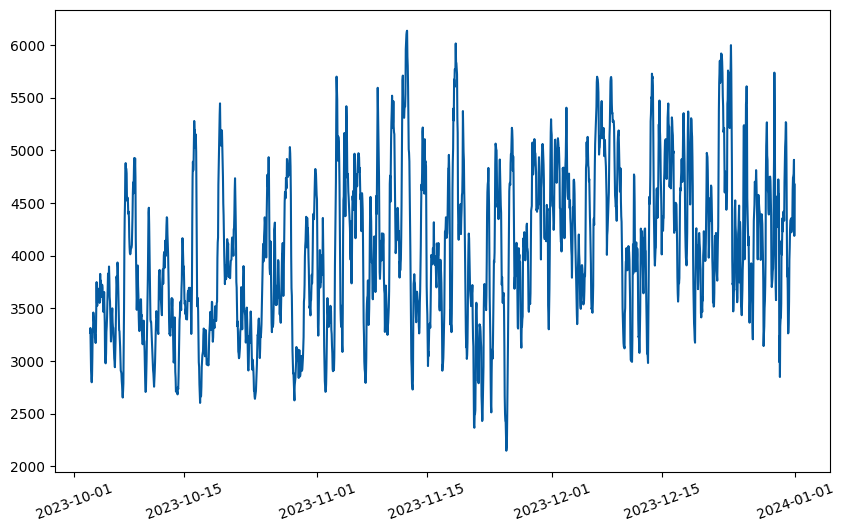

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(df.iloc[-OUR_HORIZON:, 0], df.iloc[-OUR_HORIZON:, 2], color='#045AA0')
plt.tick_params(axis='x', rotation=20);

In [16]:
nhits = NHiTS(prediction_length=OUR_HORIZON, context_length=2*OUR_HORIZON, 
              interpolation_mode='cubic-x', n_blocks=[1, 1, 2],
              learning_rate=2*1e-2, logging_metrics=nn.ModuleList([MAE(), MASE()]))
net = nhits.from_dataset(train, optimizer="Adam")

/opt/anaconda3/envs/pyver_311/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/opt/anaconda3/envs/pyver_311/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
/opt/anaconda3/envs/pyver_311/lib/python3.11/site-packages/pytorch_forecasting/models/nhits/__init__.py:199: UserWarning: In pytorch-forecasting models, on versions 1.1.X, the default optimizer defaults to 'adam', if pytorch_optimizer is not installed, otherwise it defaults to 'ranger' from pytorch_optimizer. From version 1.2.0, the default optimizer will be 'adam' regardless of whether pytorch_optimizer is installed, 

In [17]:
trainer = pl.Trainer(accelerator="mps", devices=1, 
                     max_epochs=200, log_every_n_steps=10)

trainer.fit(net, train_dataloaders=train_dataloader, val_dataloaders=valid_dataloader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type           | Params | Mode 
-----------------------------------------------------------
0 | loss            | MASE           | 0      | train
1 | logging_metrics | ModuleList     | 0      | train
2 | embeddings      | MultiEmbedding | 0      | train
3 | model           | NHiTS          | 10.8 M | train
-----------------------------------------------------------
10.8 M    Trainable params
0         Non-trainable params
10.8 M    Total params
43.343    Total estimated model params size (MB)
35        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/anaconda3/envs/pyver_311/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:475: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/opt/anaconda3/envs/pyver_311/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
/opt/anaconda3/envs/pyver_311/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


In [18]:
energy_forecast = net.predict(valid_dataloader, trainer_kwargs=dict(accelerator='cpu'), 
                              return_y=True, return_x=True, mode='raw')

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/opt/anaconda3/envs/pyver_311/lib/python3.11/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/opt/anaconda3/envs/pyver_311/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:475: Your `predict_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/opt/anaconda3/envs/pyver_311/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


In [19]:
MAE()(energy_forecast.output.prediction, energy_forecast.y)

tensor(619.4823)

In [20]:
energy_forecast

Prediction(output=Output(prediction=tensor([[[3479.4592],
         [3424.3145],
         [3503.7285],
         ...,
         [4163.4424],
         [4182.0913],
         [4139.3213]]]), backcast=tensor([[[5114.9805],
         [4812.5483],
         [4668.4126],
         ...,
         [4802.3145],
         [4770.9604],
         [2170.7563]]]), block_backcasts=[tensor([[[3621.],
         [3621.],
         [3621.],
         ...,
         [3621.],
         [3621.],
         [3621.]]]), tensor([[[4984.4180],
         [4680.0698],
         [4535.9229],
         ...,
         [4883.6836],
         [4843.4399],
         [2629.1826]]]), tensor([[[4558.9932],
         [4560.8462],
         [4560.9194],
         ...,
         [4347.0605],
         [4355.9580],
         [3970.0032]]]), tensor([[[4428.4282],
         [4428.4902],
         [4428.4287],
         ...,
         [4428.4292],
         [4428.4209],
         [4428.4287]]])], block_forecasts=[tensor([[[3621.],
         [3621.],
         [3621

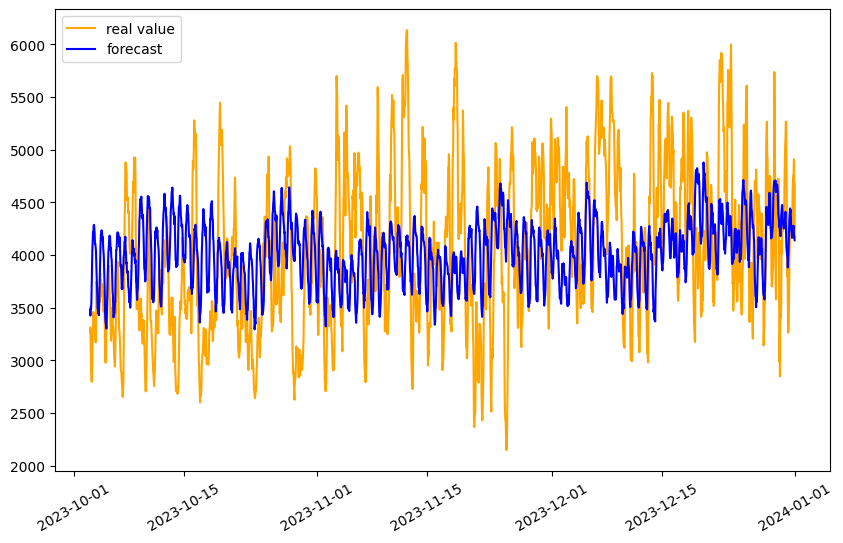

In [21]:
daterange = df.iloc[-OUR_HORIZON:, 0]
plt.figure(figsize=(10, 6))
plt.plot(daterange, energy_forecast.y[0].numpy()[0], label='real value', color='orange')
plt.plot(daterange, energy_forecast.output.prediction.numpy()[0], label='forecast',
         color='blue')
plt.tick_params(axis='x', rotation=30)
plt.legend();

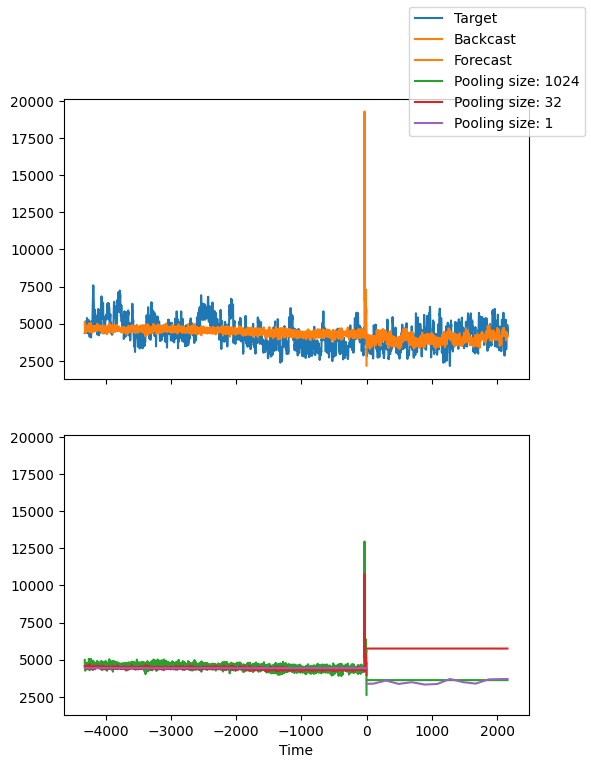

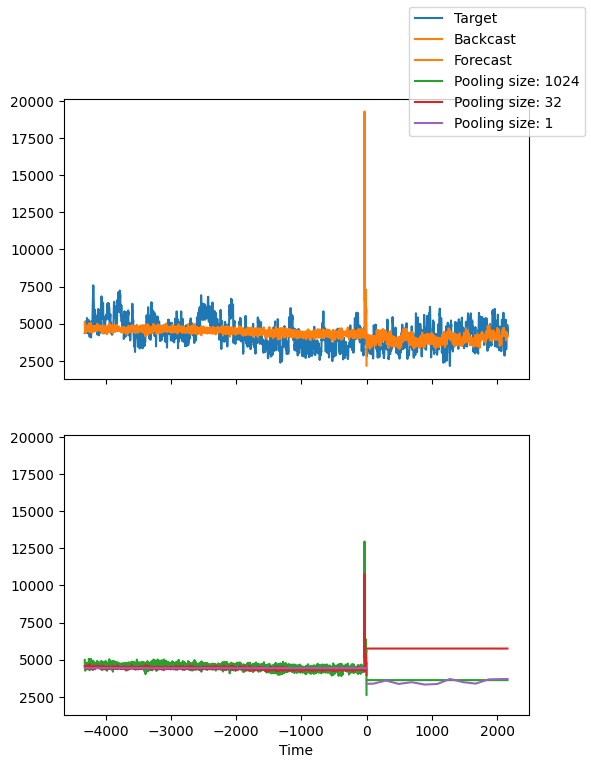

In [22]:
net.plot_interpretation(energy_forecast.x, energy_forecast.output, 0)